# Predicting Future User Adoption

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
users = pd.read_csv('takehome_users.csv')

In [4]:
users_eng = pd.read_csv('takehome_user_engagement.csv')

## Data Wrangling

In [5]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [6]:
users.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [7]:
users['object_id'].nunique()

12000

In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [9]:
users[(users['creation_source']=='GUEST_INVITE') & (users.invited_by_user_id.isnull())]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id


In [10]:
users_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


## From Users Engagment table, 
1. getting the yr and wk of users sessions
2. grouping the user session count of each user, yr and wk

In [11]:
users_eng['usage_date'] = pd.to_datetime(users_eng['time_stamp'].apply(lambda x:x[:10]),format ='%Y-%m-%d')

In [12]:
users_eng['usage_yr'] = users_eng['time_stamp'].apply(lambda x:x[:4]).astype(int)
users_eng['usage_wk'] = pd.to_datetime(users_eng['time_stamp']).apply(lambda x: x.weekofyear)

In [13]:
users_eng.head()

,time_stamp,user_id,visited,usage_date,usage_yr,usage_wk
0,2014-04-22 03:53:30,1,1,2014-04-22,2014,17
1,2013-11-15 03:45:04,2,1,2013-11-15,2013,46
2,2013-11-29 03:45:04,2,1,2013-11-29,2013,48
3,2013-12-09 03:45:04,2,1,2013-12-09,2013,50
4,2013-12-25 03:45:04,2,1,2013-12-25,2013,52


In [14]:
users_grp = pd.DataFrame(users_eng.groupby(['user_id','usage_yr','usage_wk'])['visited'].sum()).reset_index()

In [15]:
# Users having 3 sessions in a week is considered as 'Adopted User'

In [16]:
users_grp = users_grp[users_grp['visited'] >= 3]
users_grp.head()

,user_id,usage_yr,usage_wk,visited
7,2,2014,6,3
24,10,2013,9,3
30,10,2013,15,3
32,10,2013,17,3
33,10,2013,18,4


In [17]:
users_grp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33816 entries, 7 to 69262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   user_id   33816 non-null  int64
 1   usage_yr  33816 non-null  int64
 2   usage_wk  33816 non-null  int64
 3   visited   33816 non-null  int64
dtypes: int64(4)
memory usage: 1.3 MB


### Merging Users and Engagement data

In [18]:
users_df = pd.merge(users, users_grp[['user_id']],  how='left', left_on=['object_id'],right_on=['user_id'])

In [19]:
users_df['adopted_user'] = np.where(users_df['user_id'].isnull(),0, 1)

In [20]:
users_df['adopted_user'].value_counts()

1    33816
0    10556
Name: adopted_user, dtype: int64

#### Left join created duplicate rows so using drop_duplicates

In [21]:
users_df = users_df.drop_duplicates()

In [22]:
users_df.head()


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,NaN,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,NaN,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,NaN,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,NaN,0


In [23]:
users_df['last_session_creation_time'] = np.where(users_df['last_session_creation_time'].isnull(),0,users_df['last_session_creation_time'] )

In [24]:
users_df['last_session_creation_time'].max() # which is same as '2014-06-06'

1402066730.0

In [25]:
from datetime import datetime
#Timestamp to datetime object
def time_convert(x):
    if x== 0:
        x = 1402066730
    dt = datetime.fromtimestamp(x)
    #Datetime object to string
    return dt.strftime('%Y-%m-%d')

In [26]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 44371
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  12000 non-null  float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  user_id                     1444 non-null   float64
 11  adopted_user                12000 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 1.2+ MB


In [27]:
users_df['last_session_created_date'] = pd.to_datetime(users_df['last_session_creation_time'].apply(lambda x:time_convert(x)))

In [28]:
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'].apply(lambda x:x[:10]),format ='%Y-%m-%d')

In [29]:
users_df['user_tenure'] = (users_df['last_session_created_date'] - users_df['creation_time']).dt.days

In [30]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 44371
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  12000 non-null  float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  user_id                     1444 non-null   float64       
 11  adopted_user                12000 non-null  int64     

In [31]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopted_user,last_session_created_date,user_tenure
0,1,2014-04-22,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,NaN,0,2014-04-21,-1
1,2,2013-11-15,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2.0,1,2014-03-30,135
2,3,2013-03-19,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,NaN,0,2013-03-19,0
3,4,2013-05-21,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,NaN,0,2013-05-22,1
4,5,2013-01-17,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,NaN,0,2013-01-22,5


In [32]:
# Identifying why last_session_created_date column is null

In [33]:
users_df['referred_by'] = np.where(users_df['invited_by_user_id'].isnull(),0,1)

In [34]:
users_df['org_id'].value_counts()

0      319
1      233
2      201
3      168
4      159
      ... 
396      9
400      8
397      8
386      7
416      2
Name: org_id, Length: 417, dtype: int64

In [35]:
# Tenure is based on last_session_creation_tima and user_creation_time
users_df['user_tenure'] = np.where(users_df['user_tenure'] < 0 , 0, users_df['user_tenure'])

In [36]:
#users_df = pd.get_dummies(data=users_df, columns=['creation_source'])

In [37]:
### Users table before modeling

In [38]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopted_user,last_session_created_date,user_tenure,referred_by
0,1,2014-04-22,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,NaN,0,2014-04-21,0,1
1,2,2013-11-15,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2.0,1,2014-03-30,135,1
2,3,2013-03-19,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,NaN,0,2013-03-19,0,1
3,4,2013-05-21,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,NaN,0,2013-05-22,1,1
4,5,2013-01-17,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,NaN,0,2013-01-22,5,1


In [40]:
users_df.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'user_id',
       'adopted_user', 'last_session_created_date', 'user_tenure',
       'referred_by'],
      dtype='object')

In [ ]:
# getting only the columns needed


In [41]:
users_df = users_df[[ 'creation_source', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip','adopted_user', 'user_tenure', 'referred_by']]

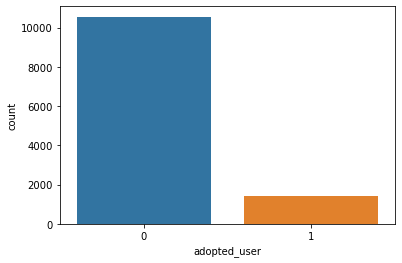

In [63]:
sns.countplot(x= 'adopted_user', data = users_df)

In [42]:
users_df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted_user,user_tenure,referred_by
0,GUEST_INVITE,1,0,0,0,1
1,ORG_INVITE,0,0,1,135,1
2,ORG_INVITE,0,0,0,0,1
3,GUEST_INVITE,0,0,0,1,1
4,GUEST_INVITE,0,0,0,5,1


## Exploratory Data Analysis

### Checking all the features for Adopted/Non-Adopted Users

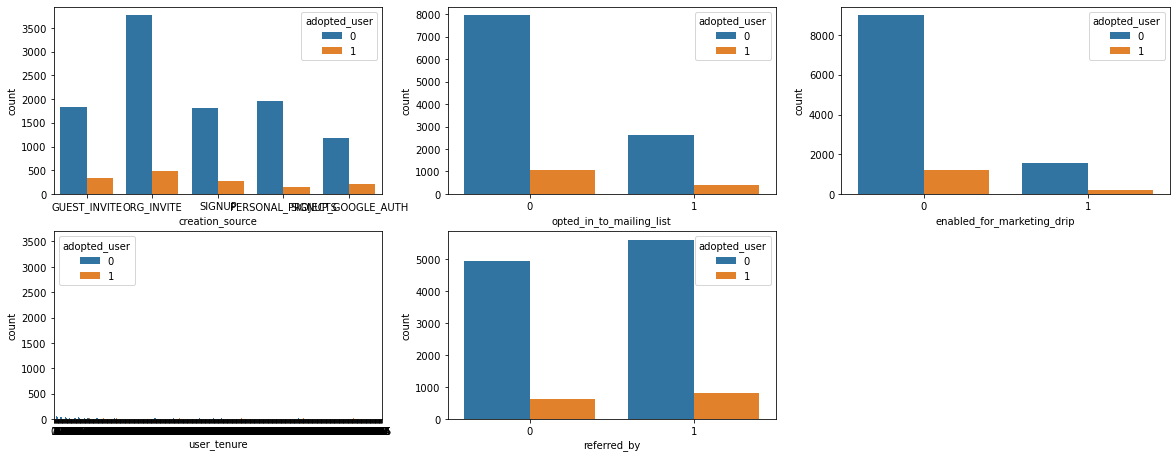

In [45]:
cnt = 1
plt.figure(figsize=(20,20))
for col in users_df.columns:
    if col != 'adopted_user':
        plt.subplot(5,3,cnt)
        sns.countplot(x= col, hue='adopted_user', data = users_df)
        cnt+= 1

(array([7817.,  749.,  564.,  465.,  474.,  401.,  424.,  379.,  369.,
         358.]),
 array([  0. ,  73.6, 147.2, 220.8, 294.4, 368. , 441.6, 515.2, 588.8,
        662.4, 736. ]),
 <a list of 10 Patch objects>)

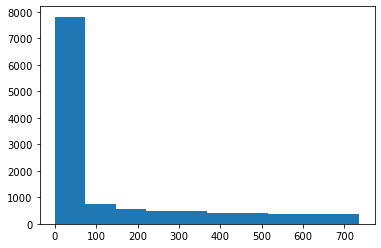

In [46]:
plt.hist(users_df['user_tenure'])

In [48]:
users_df['user_tenure'].mean(), users_df['user_tenure'].median() # right skewed  (median < mean)

(130.9695, 4.0)

In [49]:
users_df = pd.get_dummies(data=users_df, columns=['creation_source'])

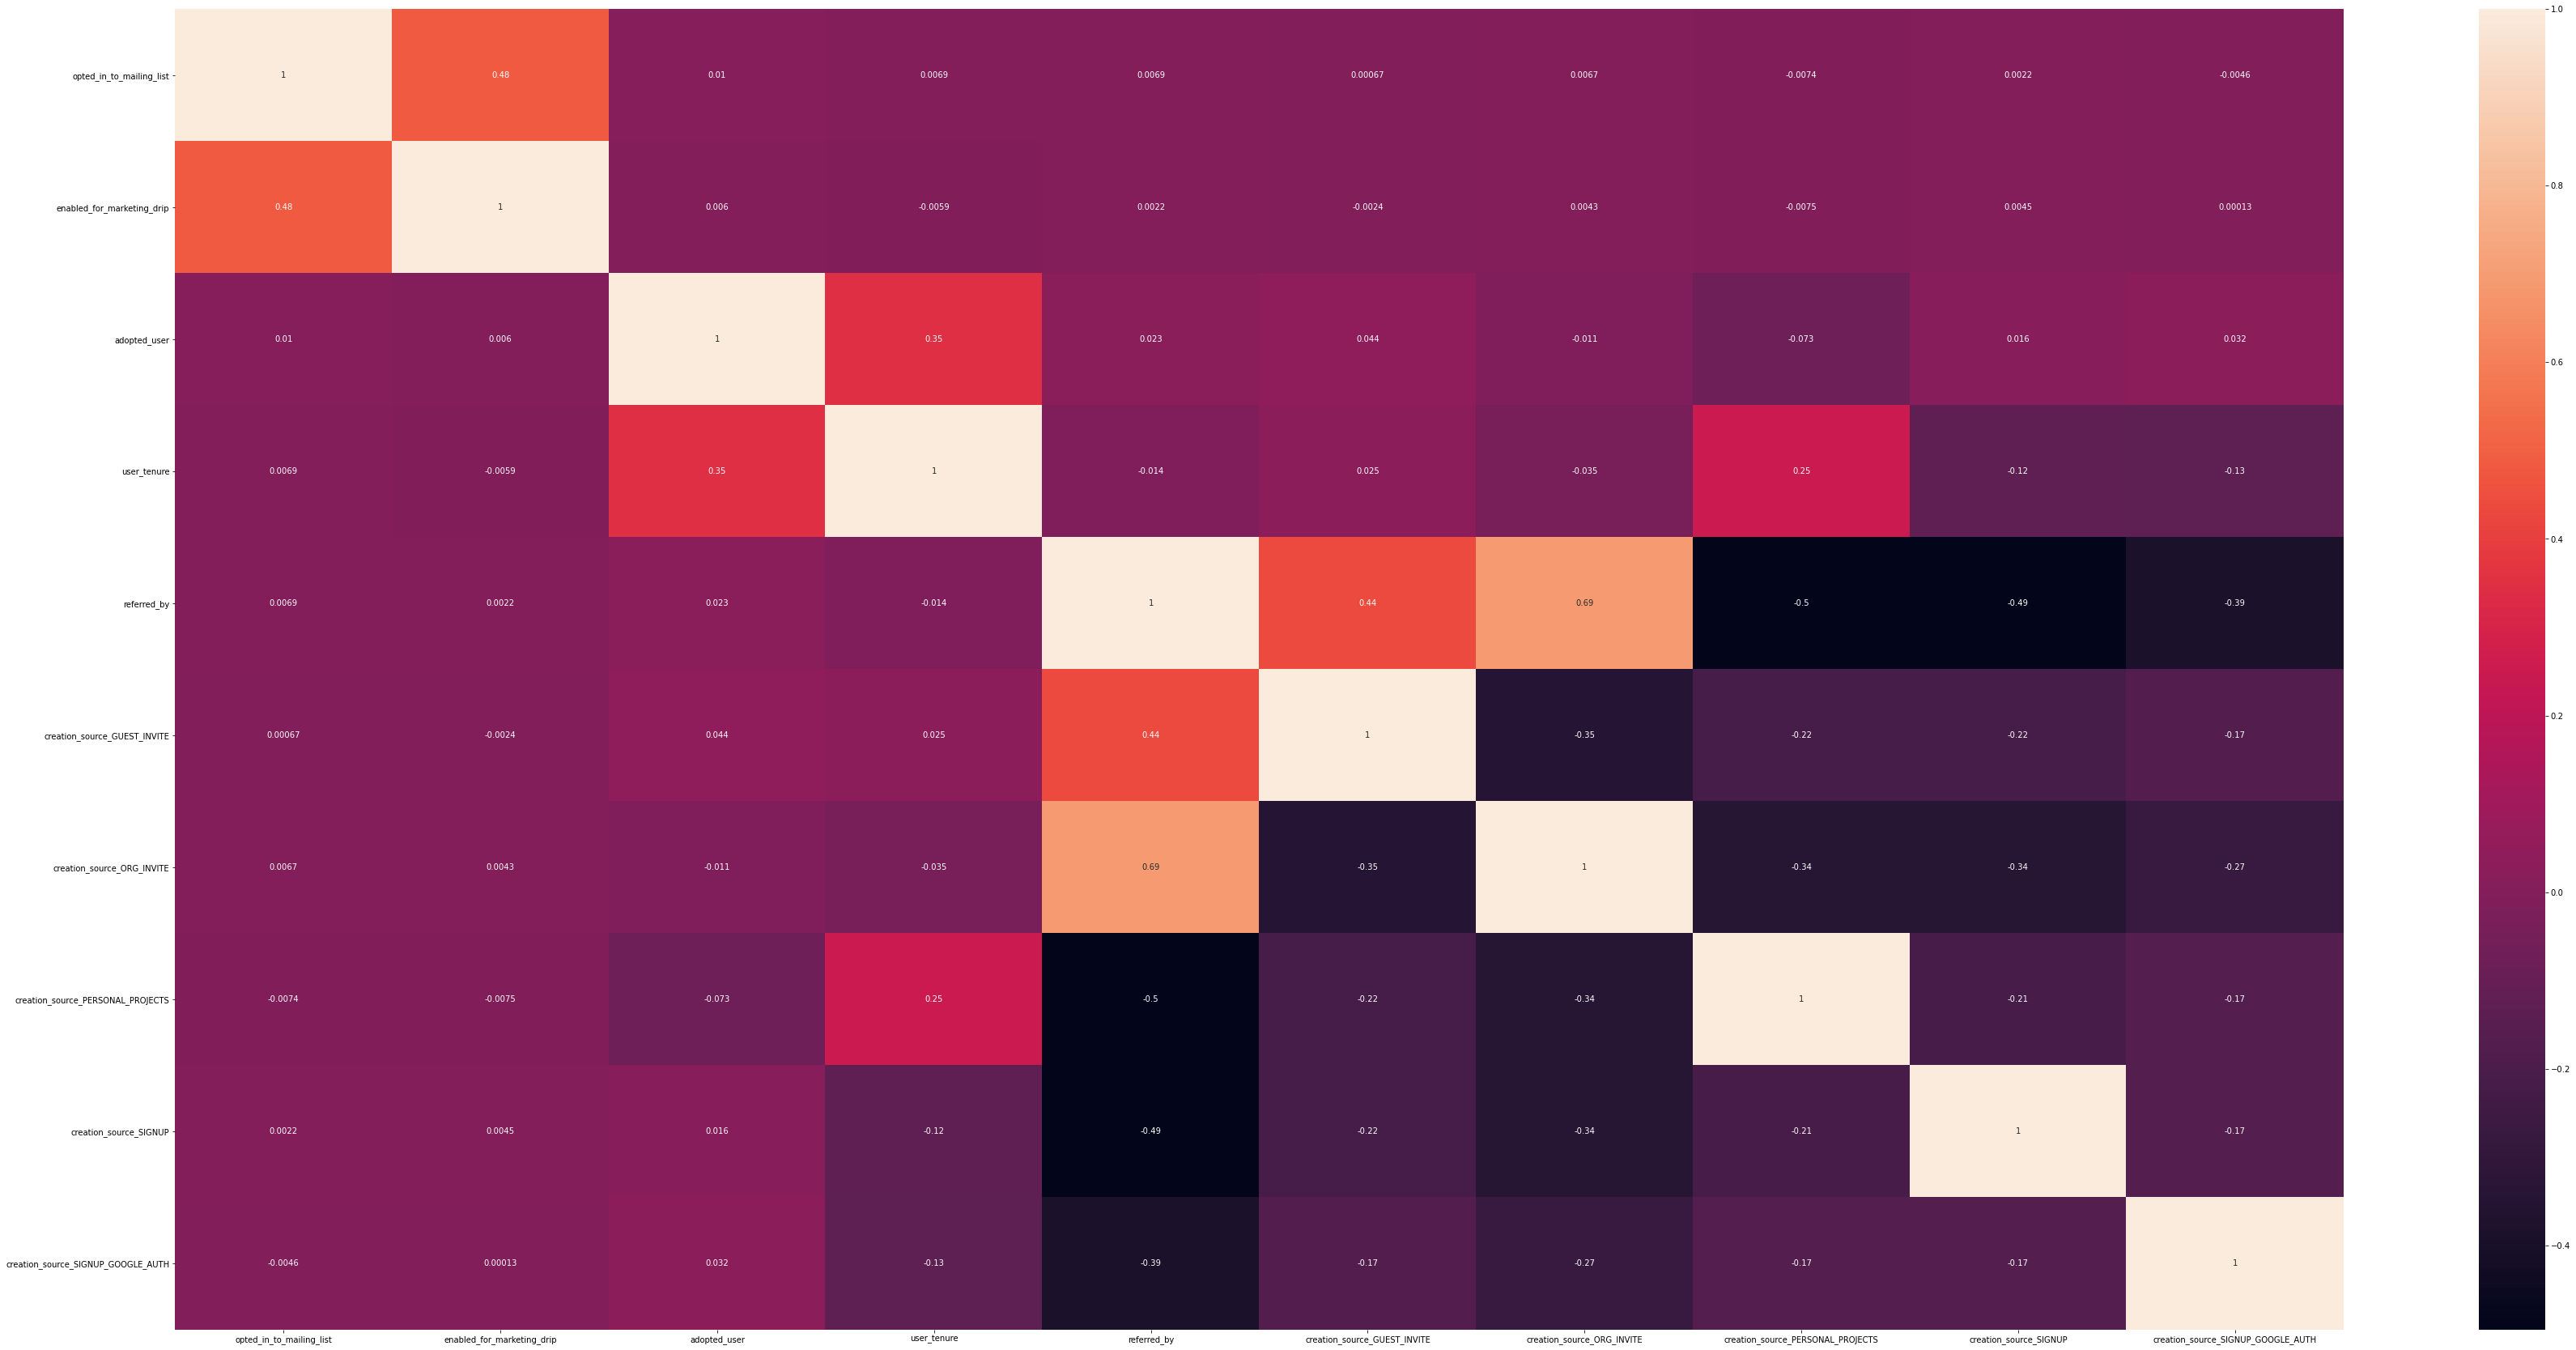

In [52]:
plt.figure(figsize=(60,30))
sns.heatmap(users_df.corr(),annot=True)

In [53]:
users_df.corr()['adopted_user']

opted_in_to_mailing_list              0.010490
enabled_for_marketing_drip            0.006010
adopted_user                          1.000000
user_tenure                           0.348419
referred_by                           0.023016
creation_source_GUEST_INVITE          0.043790
creation_source_ORG_INVITE           -0.011190
creation_source_PERSONAL_PROJECTS    -0.072669
creation_source_SIGNUP                0.016126
creation_source_SIGNUP_GOOGLE_AUTH    0.031534
Name: adopted_user, dtype: float64

opted_in_to_mailing_list


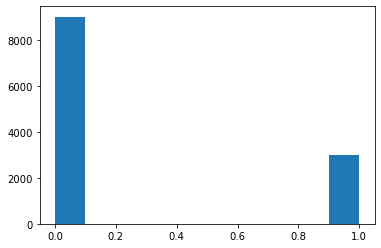

enabled_for_marketing_drip


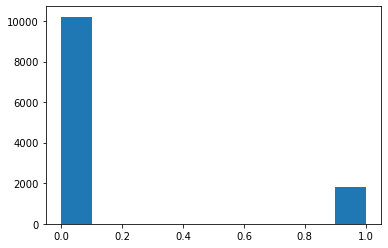

adopted_user


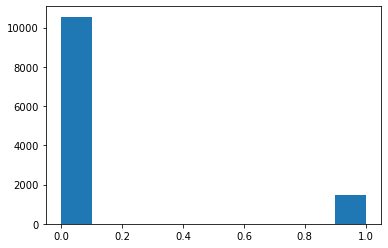

user_tenure


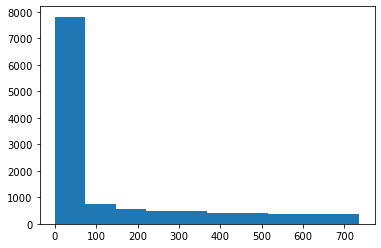

referred_by


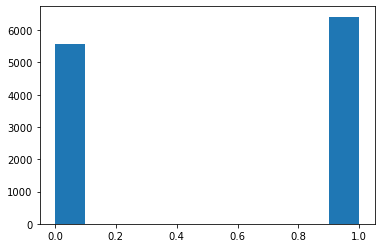

creation_source_GUEST_INVITE


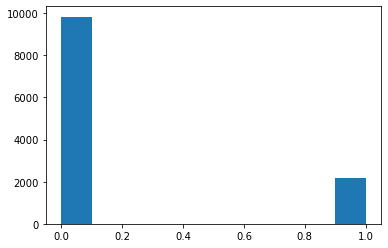

creation_source_ORG_INVITE


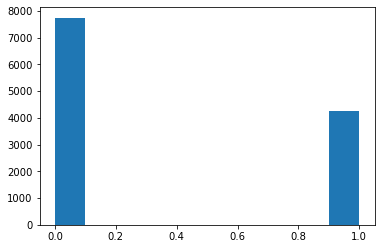

creation_source_PERSONAL_PROJECTS


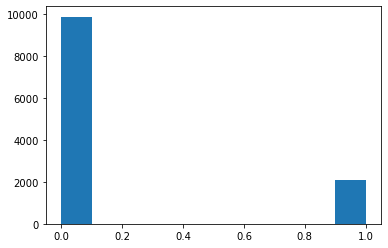

creation_source_SIGNUP


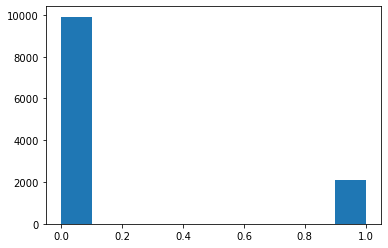

creation_source_SIGNUP_GOOGLE_AUTH


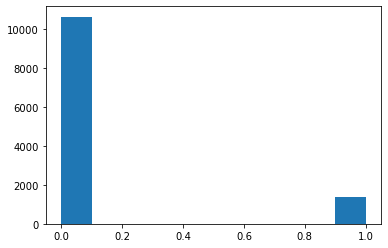

In [58]:
for col in users_df.columns:
    print (col)
    plt.hist(users_df[col])
    plt.show()

### OLS Regression Results

In [60]:
#using statsmodels

est = sm.OLS(users_df['adopted_user'],users_df.drop(['adopted_user'],axis= 1))
est2 = est.fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           adopted_user   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     311.8
Date:                Wed, 26 May 2021   Prob (F-statistic):               0.00
Time:                        16:42:47   Log-Likelihood:                -2549.7
No. Observations:               12000   AIC:                             5115.
Df Residuals:                   11992   BIC:                             5175.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
opted_in_to_mailing_list               0.0033      0.007      0.464      0.643      -0.011       0.017
enabled_for_marketing_drip             0.0045      0.009      0.517      0.605      -0.013       0.022
user_tenure                            0.0006   1.39e-05     45.614      0.000       0.001       0.001
referred_by                            0.0322      0.003     10.383      0.000       0.026       0.038
creation_source_GUEST_INVITE           0.0272      0.005      5.841      0.000       0.018       0.036
creation_source_ORG_INVITE             0.0050      0.004      1.325      0.185      -0.002       0.013
creation_source_PERSONAL_PROJECTS     -0.0855      0.007    -11.405      0.000      -0.100      -0.071
creation_source_SIGNUP                 0.0827      0.007     12.100      0.000       0.069       0.096
creation_source_SIGNUP_GOOGLE_AUTH     0.1106      0.008     13.423      0.000       0.094       0.127
==============================================================================
Omnibus:                     3952.883   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10564.029
Skew:                           1.806   Prob(JB):                         0.00
Kurtosis:                       5.842   Cond. No.                     2.96e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.15e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [61]:
users_df['adopted_user'].value_counts()

0    10556
1     1444
Name: adopted_user, dtype: int64

# Conclusions

Below are my observations
1. Loaded data into users and users_engagement dataframe
2. Based on the users_eng dataset, group the session count by user_id,year and week_number. Then filter the users having more than 3 sessions
3. Joining these users with users_engagement on user_id, and if found then Adopted User or not
4. Based on the existing features of creatime_time, last_session_creatim_time, invited by user_id, derived tenure, referred_by features
5. Using Correlation Matrix and OLS Regression results, identify the important features such as tenure, referred_by and creation_source